# Create n-gram embedding

## Short term intro
A n-gram of words is just a set of words: 
- Monograms: "of", "words", "is"
- Bigrams: "of words", "words is", "is just"
- Trigrams: "of words is", "words is just"
- etc. 

A word-embedding is a vector representation of a word (random, simplified examples): 
- "of" -> [2, 6, -1]
- "words" -> [-2, 3, 9]
- "just" -> [9, 9, -3]

The nice thing about word-embeddings is that you can compare words using mathematical functions like cosine similarity (cos_sim): 
- cos_sim(vector("cat"), vector("tiger")) = 0.95, where cos_sim is a score of similarity between two words. 

If we would like to find a vector for a ngram more than one we need a pooling function. A pooling function can for example be average, maximum, minimal, absolute maximum etc. We use average pooling. 
- average_pooling([1, 2, 3], [3, 2, 1]) = [4, 4, 4]
- abs_max_pooling([-1, -1, -3], [3, 2, 1]) = [3, 2, -3]


## Text corpus
For this notebook we will extract ngram of words from papers and embed them into ngram-embeddings. 
When we have the set of ngram-embeddings we can use a similarity function to find "similar ngrams" to what you input. 
We will in this tutorial support .pdf files. 

## Contextual model
We are not going to train any models in this tutorial, but rather use an existing contextual language model to find our embeddings.

These contextual models have often been pre-trained on a massive amount of data, so they already know a lot about a language. 

## NLP Libraries
We introduce a few highly useful NLP- libraries, that you can use for a lot more than what we do in this tutorial!

### Huggingface
https://huggingface.co/ 
Huggingface is a library full of useful datasets and pre-trained langugage models, as well as an api to make the work with huge models simple for you. We will use it to download a pre-trained bert-model, but you can acces so many other models as well. 
If you for example want to download you own multilingual translation model check out facebooks: https://huggingface.co/facebook/m2m100_418M . 


### Spacy
https://spacy.io/ 
Spacy is also a much used library in NLP. Although we in do not use it in this tutorial (we use nltk for sentence and word-tokenization insteas), it has a lot of buil-in functions useful for pre-processing text. You can f.eks. do Named Entity Recognition, POS-tagging (tag words as verbs, nouns etc). 


### Gensim
https://radimrehurek.com/gensim/intro.html
Gensim is a library specialized in representing text as semantic vectors (as out word-embeddings). You can very easily create you own set of word-embeddings or document-embeddings with this library, however we use it mainly to get functionality when comparing the word-embeddings. 


### Pymupdf
https://pymupdf.readthedocs.io/en/latest/
Helpful for extracting information such as text or images from pdf-files. 


### Pytorch 
https://pytorch.org/
Like Tensorflow, Pytorch is a framework for tensor-processing. Compatible with GPU. 

### Natural Language Toolkit (NLTK)
https://www.nltk.org/ 
Superuseful for tokenization (e.g. creating our ngram of words) and it has a lot of useful lexical resources. 

## Imports and constants

In [1]:
# glob is used for finding filepaths
import glob

# regex
import re

# numpy, useful for efficient vector operations
import numpy as np

# pymupdf for pdf parsing (I have no idea why it is called fitz...)
import fitz

# natural langauge toolkit
import nltk
from nltk.tokenize import word_tokenize

# pytorch 
import torch

# transformoer models from huggingface
from transformers import BertTokenizerFast, BertModel

# gensim library
from gensim.models import KeyedVectors

In [2]:
# define constants 
PDF_FOLDER = "D:/master_papers/Papers/*/*.pdf"
NGRAMS = 2
MIN_COUNT = 2
LAYER = 11

## Fetch data from pdf-files

### Define a few functions for extracting only relevant text
Based on the format that pymupdf outputs a parsed pdf we only extract the text. The text is grouped according to which font they use. The aim is then to only extract the text of the main font to avoid bibliography etc. to be included in the text corpus. 

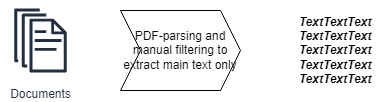

In [3]:
def get_text_by_font(doc): 
    """Extract all the text with font information from document

    Parameters
    ----------
    doc : object
        A pymupdf document object

    Returns
    -------
    dict
        Dictionary with font as the key and the text as the content
    """
    text_by_font = {}
    for page in doc.pages(): 
        text_page = page.get_text("dict")
        for block in text_page['blocks']: 
            if ('lines' in block):
                for line in block['lines']: 
                    for span in line['spans']: 
                        font_id = span['font']+"_"+str(round(span['size'])) # font_id equals font + size
                        if (font_id in text_by_font): 
                            text_by_font[font_id] += (" "+span['text'])
                        else: 
                            text_by_font.update({font_id: span['text']})
    return text_by_font


def get_text_font_amount(text_by_font): 
    """Count and sort the text lengts (in word) for each font. 
        We do this to avoid including bibliography etc. in the text corpus

    Parameters
    ----------
    text_by_fon : dict
        Dictionary with font as the key and the text as the content

    Returns
    -------
    list
        Sorted fonts according to text length
    """
    token_len_fonts = []
    for font_id, text in text_by_font.items(): 
        token_len = len(text.split())
        token_len_fonts.append((token_len, font_id))
    # sort so the one with the most tokens are first
    token_len_fonts.sort(reverse = True)
    return token_len_fonts

### Extract text from the given pdf-files

In [4]:
# define the filenames,  probably in format: paper_folder/*.pdf 
filenames = glob.glob(PDF_FOLDER)

In [5]:
# iterate through all filenames to extract text from each file
text_articles = []

for filename in filenames[:50]: 
    # parse pdf with pymupdf
    doc = fitz.open(filename) 
    # we use a try catch, because some pdf-files do not work
    try: 
        # find the text belonging to the most common font
        text_by_font = get_text_by_font(doc)
        token_len_fonts = get_text_font_amount(text_by_font)
        relevant_font = token_len_fonts[0][1]
    except: 
        #print(filename)
        continue
    # add relecant text to array
    text_articles.append(text_by_font[relevant_font])

### Divide corpus into sentences
An article is often too long for our contextual model (comes later in the script), so we divide the text corpus into sentences.

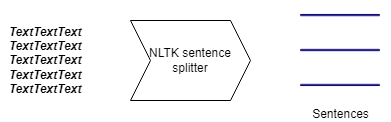

In [6]:
sentences_lower = []
for article in text_articles: 
    try: 
        doc = nltk.sent_tokenize(article)
    except: 
        #print(len(article))
        continue
    for sent in doc: 
        sentences_lower.append(str(sent).lower())

## Find n-grams in the text corpus
In this example we will find bigrams of words, meaning two and two words from the text. 
We also filter out some of the bigrams based on non-albhabetic characters and frequency.

As you increase the number of n-words in you ngrams the amount of different combinations also increase!

In the filtering mechinism it is possible to add or remove filters, depending how strict you are. 

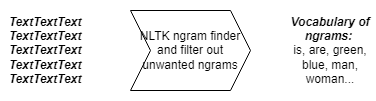

In [7]:
# we first join all the aritcles to one big text chunk with dubbel-line space and make it lowercased
text_data = " \n\n".join(text_articles)
text_list = word_tokenize(text_data.lower())

In [8]:
# nltk has a in-built function for finding ngrams
word_ngrams = nltk.ngrams(text_list, NGRAMS) # to make trigrams, 4grams ... change the number accordingly

In [9]:
# we find how ofter each bigram occurs
fdist = nltk.FreqDist(word_ngrams)

In [10]:
# we print the 10 most common bigrams in the text 
print("Most common word ngrams: ", fdist.most_common(10))

Most common word ngrams:  [((',', 'and'), 2412), (('of', 'the'), 1952), ((')', '.'), 1741), (('.', 'the'), 1536), ((',', 'we'), 1326), (('.', 'in'), 1309), (('in', 'the'), 1301), (('et', 'al'), 1250), (('al', '.'), 1250), (('.', 'we'), 1234)]


### Filtering

In [11]:
# filter out the unvanted ngrams
filtered_ngrams = []
for k,v in fdist.items():
    enough_occurances = (v >= MIN_COUNT) 
    includes_character = all([bool(re.search("[a-z]+", word)) for word in k])
    if (enough_occurances and includes_character): 
        filtered_ngrams.append((k, v))

In [12]:
# print the amount of grams before and after filtering
print("Uniqe word ngrams: ", len(fdist.keys()), "\nUnique word ngrams after filtering: ", len(filtered_ngrams))

Uniqe word ngrams:  142301 
Unique word ngrams after filtering:  29546


In [13]:
# we merge the two words with space to create a string of the bigram
filtered_ngrams_list = [" ".join(gram[0]) for gram in filtered_ngrams]

## Embeddings from contextual model

### Load contextual model: BERT
BERT stands for Bidirectional Encoder Representations from Transformers and is a deep neural network pre-trained on a massive amount of text data. Paper:  https://arxiv.org/abs/1810.04805. Blog explaining BERT: https://jalammar.github.io/illustrated-bert/ . 

BERT has 12 stacked encoder layers, each token gets a new vector representation (hidden state) after each layer. Any of these can in principel be used as a word-representation, however it has been proven that later hidden states include more semantic value which we see as useful for this project. 

In [14]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# define model name
model = 'bert-base-uncased' #for norwegian you can use: 'NbAiLab/nb-bert-base' or 'ltgoslo/norbert'

# the tokenizer plits the input text into tokens, which in this case is called wordpieces 
tokenizer = BertTokenizerFast.from_pretrained(model)

# download the model online
bert_model = BertModel.from_pretrained(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# change to cuda cores if a gpu is available
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Obtain embeddings from BERT

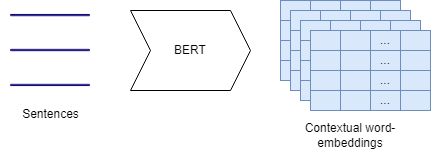

In [17]:
# bert create a vector representation (actually many, one between each layer in the model)
# this function fetches the tokens and embeddings 
def sent_to_embedding_tokens(sent): 
    """Inference sentence through BERT to obtain output vectors and 
         tokens.

    Parameters
    ----------
    sent : str
        Input sentence

    Returns
    -------
    list 
        tokenized_sent is the input sentence in wordpieces from the tokenizer
    tensor
        token_embeddings is all the output vectors from each token after each layer
    """
    with torch.no_grad(): 
        tokenized_sent = tokenizer.tokenize(sent)
        # check if tokens are too long
        if (len(tokenized_sent) > 500): 
            return False, False
        # tokenize sentence to model inputs
        inputs = tokenizer(sent, return_tensors = "pt")
        # inference the inputs through the BERT model to obtain token-embeddings
        outputs = bert_model(**inputs.to(device), output_hidden_states=True)
        # according to the huggingface library, the 2. element contain all the hidden states
        hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0) #stack all hidden states into same tensor
        token_embeddings = token_embeddings.squeeze(dim=1) # remove empty dimension
        token_embeddings = token_embeddings.permute(1,0,2)[1:-1] # change dimensions and remove remove cls and sep token
    
    return tokenized_sent, token_embeddings


def get_word_index2token_index(tokenized_sent, word_array): 
    """Since the tokenizer can divide a word into multiple wordpieces
        we map the tokens to each word

    Parameters
    ----------
    tokenized_sent : list
        list of wordpieces
    word_array: list
        list of words

    Returns
    -------
    dict 
        dictionary to map word indecies to token indecies

    """
    current_word = word_array[0]
    word_index = 0
    word_index2token_index = {}
    current_token = ""
    for i, token in enumerate(tokenized_sent): 
        current_token += (re.sub("^##", "", token)) # it is standard for BERT tokenizer to add ## for subpieces not first in a word
        if (current_word == current_token): 
            if (word_index in word_index2token_index): 
                word_index2token_index[word_index].append(i)
            else: 
                word_index2token_index.update({word_index: [i]})
            word_index += 1
            # check if it was the last word
            if (len(word_array) <= word_index): 
                break
            current_word = word_array[word_index]
            current_token = ""
        else: 
            if (word_index in word_index2token_index): 
                word_index2token_index[word_index].append(i)
            else: 
                word_index2token_index.update({word_index: [i]})
    return word_index2token_index

def get_ngrams_and_indecies(word_index2token_index, word_array): 
    """Extract the ngrams and map wordpieces to ngrams

    Parameters
    ----------
    word_index2token_index : dict
        word indecies to token indecies mapping
    word_array: list
        list of words

    Returns
    -------
    list 
        ngrams is all the ngrams in the word_array
    ngram_token_indecies
        mapping from each ngram to wordpiece indecies

    """
    ngrams = [ngram for ngram in nltk.ngrams(word_array, NGRAMS)]
    ngram_word_indecies = [[i+j for j in range(len(ngrams[0]))] for i in range(len(ngrams))]
    ngram_token_indecies = []
    for word_indecies in ngram_word_indecies:  
        ngram_token_indecies.append([token_index for word_index in word_indecies for token_index in word_index2token_index[word_index]])
    return ngrams, ngram_token_indecies

## Find relevant ngrams

In [18]:
def get_filtered_ngrams_in_sent(tokenized_sent, sent): 
    """Find and filter out the relevant ngrams from the input sentence

    Parameters
    ----------
    tokenized_sent : list
        list of wordpieces 
    snet: str
        input sentence

    Returns
    -------
    list 
        list of tuples with name of ngram and the relevant wordpiece indecies
    """
    word_array = word_tokenize(sent)
    word_index2token_index = get_word_index2token_index(tokenized_sent, word_array)
    ngrams, ngram_token_indecies = get_ngrams_and_indecies(word_index2token_index, word_array)
    # make the ngram of words into one string 
    ngrams_in_sent = [" ".join(ngram) for ngram in ngrams]
    
    filtered_ngrams_in_sent = []
    for i, ngram_in_sent in enumerate(ngrams_in_sent): 
        if(ngram_in_sent in filtered_ngrams_list): 
            filtered_ngrams_in_sent.append((ngram_in_sent, ngram_token_indecies[i]))
            
    return filtered_ngrams_in_sent


## Average contextual embeddings
In the end we create a n-gram to vector mapping list, so each n-gram can be looked up in vector format. We do this by taking the average of all the contectual embeddings from the text corpus each time a n-gram appears.

Embeddings for each word: 

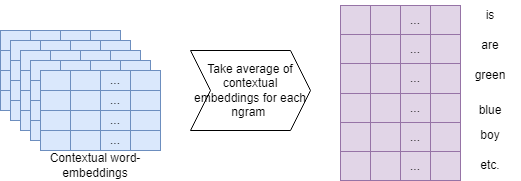


 

Embeddings for bigrams: 

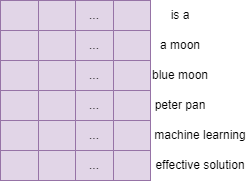

In [19]:
def insert_embedding_in_dict(ngram_phrase, ngram_embedding, ngram_embedding_dict): 
    """Insert new ngram phrase, or add ngram embedding to the current embedding
        average of the ngram phrase

    Parameters
    ----------
    ngram_phrase : str
        the gram phrase 
    ngram_embedding: array
        the contextual embedding from the sentence
    ngram_embedding_dict: dict
        dictionary with ngram_phrase to average embedding and count mapping

    Returns
    -------
    dict 
        updated ngram_embedding_dict
    """
    if (ngram_phrase in ngram_embedding_dict): 
        old_embedding = ngram_embedding_dict[ngram_phrase][0]
        old_occurances = ngram_embedding_dict[ngram_phrase][1] 
        
        # here we use "mean-pooling" over all the contextual embeddings to obtain our static ngram-embedding
        new_embedding = ngram_embedding/(old_occurances+1) + (old_embedding*old_occurances)/(old_occurances+1)
        ngram_embedding_dict[ngram_phrase] = (new_embedding, old_occurances+1)
    else: 
        ngram_embedding_dict.update({ngram_phrase: (ngram_embedding, 1)})
        
    return ngram_embedding_dict

## Create ngram-embeddings by iterating over text corpus

In [20]:
ngram_embedding_dict = {}

In [21]:
# interate through each sentence in the corpus to find ngram word-embeddings and add them to embedding dictionary
for sent in sentences_lower: 
    try: 
        tokenized_sent, token_embeddings = sent_to_embedding_tokens(sent)
        # you can try changing the layer and see if it makes a difference
        token_embeddings = token_embeddings.to("cpu").detach().numpy()[:, LAYER, :]
        ngrams_in_list = get_filtered_ngrams_in_sent(tokenized_sent, sent)

        for ngram_tuple in ngrams_in_list: 
            ngram_embedding = np.mean(token_embeddings[ngram_tuple[1]], axis=0)
            ngram_embedding_dict = insert_embedding_in_dict(ngram_tuple[0], ngram_embedding, ngram_embedding_dict)
    except: # some text string do not work because tokenization do not match... 
        #print(sent)
        continue

Token indices sequence length is longer than the specified maximum sequence length for this model (6868 > 512). Running this sequence through the model will result in indexing errors


## Make the embeddings comparable
We use the gensim library only to avoid programming a "most_similar" function ourselves. With gensim you can however create you own word-embeddings from scratch based on architectures like W2V and Glove.
Papers: https://arxiv.org/abs/1301.3781 (word2vec), https://nlp.stanford.edu/pubs/glove.pdf (Glove)

The library als oprovide a simple storing format that lets us easiy save and reload the ngram word-embeddings. 

### Store the embedding with gensim format

In [22]:
ngram_phrases = np.array(list(ngram_embedding_dict.keys()))
ngram_embeddings = np.array([gram[0] for gram in ngram_embedding_dict.values()])

In [23]:
# make word-embedding object from phrase embedding
word_model = KeyedVectors(vector_size = len(ngram_embeddings[0]))
word_model.add_vectors(ngram_phrases, ngram_embeddings)

In [24]:
# save word-embeddings
word_model.save("academic_ngrams_"+str(NGRAMS)+".kv")

### Test embeddings

In [25]:
word_model.most_similar("number of", topn = 10)

[('numbers of', 0.9339830875396729),
 ('the number', 0.9241423010826111),
 ('of number', 0.8968838453292847),
 ('amount of', 0.8946460485458374),
 ('total number', 0.893581211566925),
 ('of total', 0.8915960788726807),
 ('set of', 0.8795614242553711),
 ('percentage of', 0.8719803690910339),
 ('and number', 0.8712414503097534),
 ('selection of', 0.862882673740387)]